loss is [4.391425   0.01717529 4.4086003 ]
loss is [1.3781015e-03 1.2485710e-07 1.3782264e-03]
loss is [3.6330952e-04 9.2701539e-06 3.7257967e-04]
loss is [0.00055062 0.00034114 0.00089176]
loss is [1.9442843e-04 7.2115419e-08 1.9450055e-04]
loss is [1.5554903e-04 7.5627868e-06 1.6311182e-04]
loss is [1.06978434e-04 7.09769381e-07 1.07688204e-04]
loss is [8.2508479e-05 1.1556041e-06 8.3664083e-05]
loss is [6.108536e-05 7.858953e-09 6.109322e-05]
loss is [5.3349420e-05 2.7188623e-06 5.6068282e-05]
-0.02937234379351139
loss is [5.1611805e+00 5.1146289e-03 5.1662951e+00]
loss is [2.6589161e-01 7.0627475e-06 2.6589867e-01]
loss is [0.0027385  0.00018414 0.00292264]
loss is [1.1426532e-03 4.7902238e-05 1.1905554e-03]
loss is [4.4316211e-04 2.6524512e-07 4.4342736e-04]
loss is [2.100465e-04 4.721504e-06 2.147680e-04]
loss is [8.0752332e-05 3.8997273e-06 8.4652056e-05]
loss is [0.00948532 0.0033513  0.01283662]
loss is [0.00372192 0.00052923 0.00425115]
loss is [0.00202615 0.00095331 0.002979

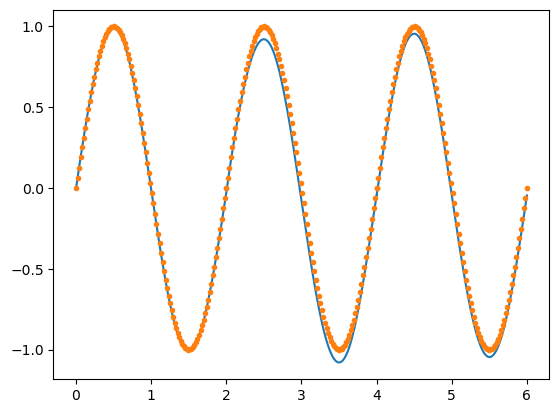

In [3]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

solver = CloudPointSolver(
    model = [1, 100, 100, 100, 1],
    optimizer = "adam"
    )

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx - torch.pi * torch.cos(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num

bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num

T_iter = 3
epoch_per_iter = 1000

x_all = []
y_all = []

for T_id in range(T_iter):
    ## define a pde
    t_span_start = 2*T_id
    t_span_end = 2*T_id+2 +0.2

    pde_input = D1Field([t_span_start, t_span_end]).get_field_rand(pde_epoch_size)
    pde_output = np.zeros([pde_epoch_size,1])

    ## define a bc
    bc_input = np.array([[t_span_start]])
    bc_output = np.zeros([bc_epoch_size ,1])
    if T_id != 0:
        bc_output[0] = last_flame_data
    
    solver = CloudPointSolver(
        [[pde_input, pde_output],[bc_input, bc_output]],
        [pde_loss,data_loss],
        model = [1, 100, 100, 100, 1],
        optimizer = "adam",
        batchsize = [pde_batch_size,bc_batch_size])

    for epoch_local_id in range(epoch_per_iter):
        epoch_id = T_id * epoch_per_iter + epoch_local_id
        solver.train_step()
        if epoch_local_id % 100 == 0:
            solver.test_step(print_flag=True)

    x_cpu = np.linspace(t_span_start, t_span_start + 2, 100).reshape(100,1)
    y_cpu = solver.model_eval(x_cpu)
    
    last_flame_data = solver.model_eval([[t_span_start + 2]]).item()
    print(last_flame_data)

    if T_id == 0:
        x_all = x_cpu
        y_all = y_cpu
    else:
        x_all = np.vstack([x_all,x_cpu])
        y_all = np.vstack([y_all,y_cpu])

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_all,y_all)
ax.plot(np.array(x_all),np.sin(np.pi*np.array(x_all)),'.')